Working on just the Mega-MUSCLES G140M spectra

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [27]:
datapath = 'raw_data/'
outpath = 'mm_x1ds/'
flts = glob.glob(datapath + '*flt.fits*')
oref="${CRDS_PATH}/references/hst/oref/"
ourroots = ['odlm41020','odlm41030','odlm41040','odlm41050']

odlm41020 needs the headers updated

In [9]:
raw = datapath+ourroots[0]+'_raw.fits'
hdul = fits.open(raw)

In [10]:
hdul[1].header['EXPTIME']

0.0

In [11]:
hdr = hdul[0].header
expt = (hdr['TEXPEND']  - hdr['TEXPSTRT']) * 86400
print(expt)
hdul.close()

2709.999936330132


In [12]:
fits.setval(raw, 'TEXPTIME', value=expt)
fits.setval(raw, 'EXPTIME',  ext=1, value=expt)

In [13]:
fits.getheader(raw,1)['EXPTIME']

2709.999936330132

In [19]:
stistools.calstis.calstis(raw, wavecal= datapath+'odlm41020_wav.fits',outroot=datapath+'odlm41020_new',  verbose=True, trailer='trl_files/odlm41020_recal.trl')

Appending to trailer file trl_files/odlm41020_recal.trl
Running calstis on raw_data/odlm41020_raw.fits
  ['cs0.e', '-v', 'raw_data/odlm41020_raw.fits', 'raw_data/odlm41020_new', '-w', 'raw_data/odlm41020_wav.fits']


0

In [28]:
mmflts = []
for flt in flts:
    if flt[-18:-9] in ourroots:
        mmflts.append(flt)
mmflts

['raw_data/odlm41020_flt.fits',
 'raw_data/odlm41040_flt.fits',
 'raw_data/odlm41030_flt.fits',
 'raw_data/odlm41050_flt.fits']

In [37]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

In [52]:
centab = Table.read('mm_trace_centers.ecsv')
centab

ROOTNAME,XCOL,A2CENTER,UNCERTAIN
str9,float64,float64,float64
odlm41040,383.85317751133266,425.6280002264092,0.0
odlm41020,383.85317751133266,405.770329070397,0.0
odlm41030,382.7797898812779,404.69694144034236,0.0
odlm41050,386.5366465864694,405.770329070397,0.0


odlm41020


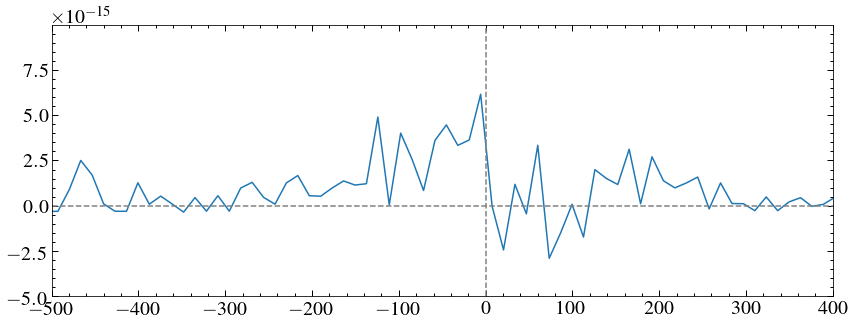

odlm41040


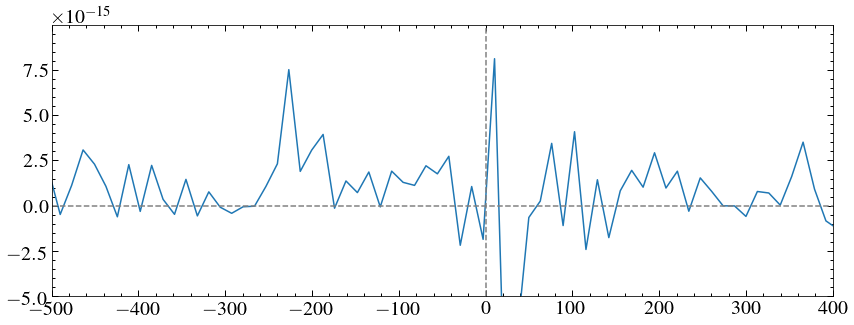

odlm41030


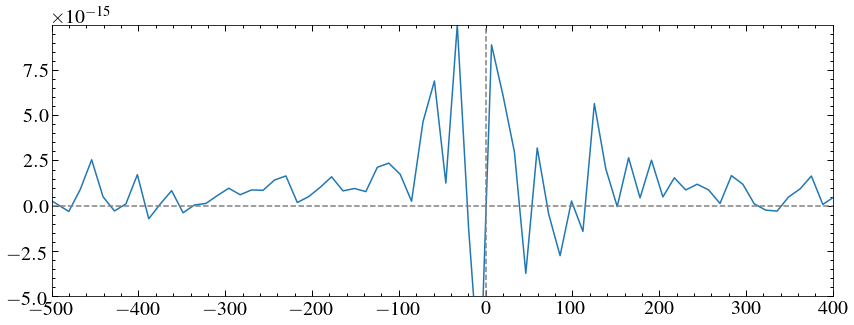

odlm41050


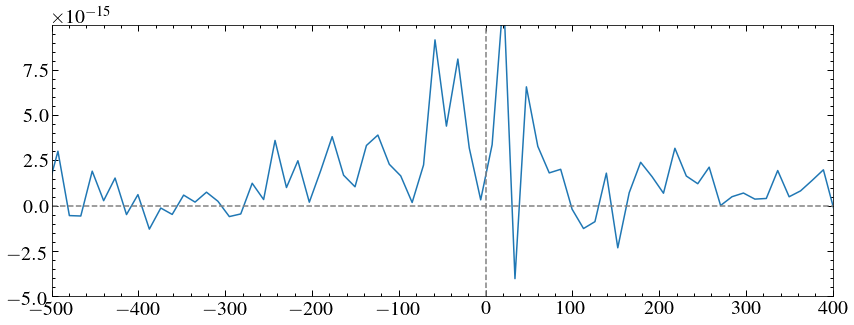

(-500, 400)

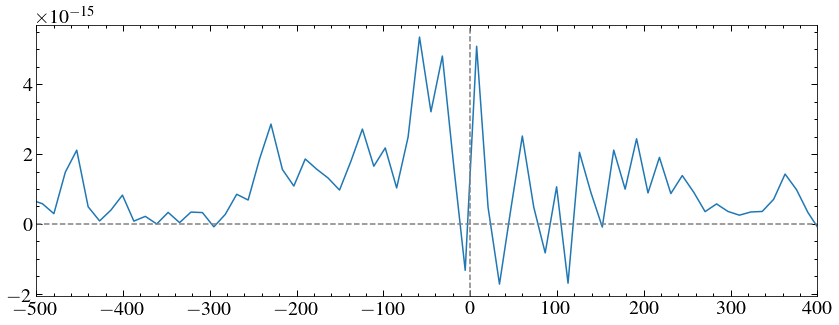

In [96]:
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

a2adjust = [-0,0,0,0]

f_new = []
e_new = []

for i, flt in enumerate(mmflts):
    hdr = fits.getheader(flt, 0)
    #build trace grid
    if i == 0:
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        
    rootname =  hdr['ROOTNAME']
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    a2center = get_a2center(x,y, tracegrid)     #adjust measured a2 center to central point
    stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center+a2adjust[i],maxsrch=0)
    x = outpath+rootname+'_new_x1d.fits'
    data = fits.getdata(x, 1)[0]
    rootname = fits.getheader(x)['ROOTNAME']
    first = True
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
    print(rootname)
    plt.plot(v, fi)
    plt.axvline(0, ls='--', c='0.5')
    plt.axhline(0, ls='--', c='0.5')
    plt.xlim(-500, 400)
    plt.ylim(-0.5e-14, 0.999e-14)
    plt.show()
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        wi, fi, ei  = resample.bintogrid(wi, fi, newx=w_new, dx=ei)
    f_new.append(fi)
    e_new.append(ei)
    
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
#f_av, e_av = new_coadd(np.array(f_new), np.array(e_new))
#plt.step(w_dop, f_av, where='mid')
f_av = np.average(f_new, axis=0)
#plt.step(w_dop, f_av, where='mid')
plt.plot(w_dop, f_av)
plt.axvline(0, ls='--', c='0.5')
plt.axhline(0, ls='--', c='0.5')
plt.xlim(-500, 400)    

odlm41050
odlm41040
odlm41020
odlm41030


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(-500, 400)

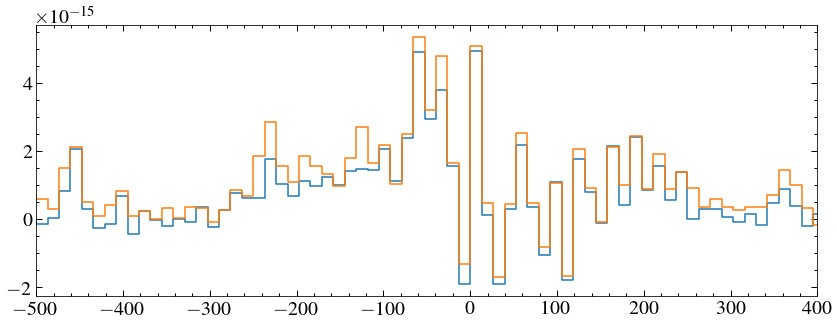

In [60]:
outpath

'mm_x1ds/'